In [51]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle
from matplotlib.widgets import Button
from matplotlib.patches import Circle
import pandas as pd
import numpy as np
import itertools
import heapq
from shapely import *
from shapelysmooth import *
import copy
import closed_path
import clp_test
import math

def main(choice1, choice2):
    global col_i, prev_fill_color, fills, colors, fig, ax, fill_image, fill_x, fill_y, prev_fill_color, dist, fill, flood_fill, path_points, valid_cols, valid_combinations, combs, choice, int_points, valid_points, adj_cols_path, cut, sdists, edists, sm_lines, close_to_start, close_to_end, ref_grid, grid, pa_points, ref_grid, grid, new_r, ref_r, movements, heuristic, get_neighbors, astar
    global show_color, show_figs
    show_color = choice1
    show_figs = choice2

    df = pd.read_csv(r'C:\Users\zm03701\Desktop\600x600 Sprouts\sprouts_points.csv')
    points = np.array(df)[-1][0][2:-2].split('), (')
    if np.array(df)[-1][1] != '[]':
        points1 = np.array(df)[-1][1][2:-2].split('), (')
    points2 = np.array(df)[-1][-1][2:-2].split('), (')
    fixed_points = []
    all_points = []
    deg1_points = []
    for interm in points:
        fixed_points.append((float(interm.split(', ')[0]), float(interm.split(', ')[1])))
    if np.array(df)[-1][1] != '[]':
        for interm in points1:
            deg1_points.append((float(interm.split(', ')[0]), float(interm.split(', ')[1])))
    for interm in points2:
        all_points.append((float(interm.split(', ')[0]), float(interm.split(', ')[1])))

    image_path = r'C:\Users\zm03701\Desktop\600x600 Sprouts\sprouts_img.png'
    #image_path = r'C:\Users\zm03701\Pictures\sprouts1.png'
    image = Image.open(image_path)
    width, height = image.size

    colors = [(255, 102, 102), (255, 178, 102), (255, 255, 102), (102, 255, 102), (102, 255, 180), (102, 255, 255), (102, 178, 255), (102, 102, 255), (178, 102, 255), (255, 102, 255), (255, 102, 178), (255, 255, 255), (255, 50, 50), (255, 128, 0), (255, 255, 0), (0, 255, 0), (0, 255, 158), (0, 255, 255), (0, 128, 255), (0, 0, 255), (127, 0, 255), (255, 0, 255), (255, 0, 127), (128, 128, 128)]
    col_i = 0
    fig, ax = plt.subplots()
    plt.imshow(image)
    plt.axis('off')

    fill_image = image.copy()
    cursor = Rectangle((0, 0), 0, 0, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(cursor)

    fill_x, fill_y = 0, 0
    prev_fill_color = (255, 255, 0, 255)

    def dist(tupl1, tupl2):
            return ((tupl2[0] - tupl1[0]) ** 2 + (tupl2[1] - tupl1[1]) ** 2) ** 0.5

    def fill(x, y):
        global colors, col_i, fig, ax, fill_image, fill_x, fill_y, prev_fill_color, dist, fill, flood_fill
        fill_x, fill_y = int(x), int(y)

        current_fill_color = fill_image.getpixel((fill_x, fill_y))

        if current_fill_color[0:3] != (240, 240, 240):
            return

        if col_i == len(colors):
            col_i = 0

        fill_color = colors[col_i]
        col_i += 1
        flood_fill(fill_color)
        plt.draw()

    def flood_fill(fill_color):
        global colors, col_i, fig, ax, fill_image, fill_x, fill_y, prev_fill_color, dist, fill
        width, height = fill_image.size
        pixels = fill_image.load()
        target_color = pixels[fill_x, fill_y]

        stack = [(fill_x, fill_y)]
        visited = set()

        while stack:
            x, y = stack.pop()
            if (x, y) in visited:
                continue

            visited.add((x, y))

            if (
                0 <= x < width and
                0 <= y < height and
                pixels[x, y] == target_color
            ):
                pixels[x, y] = fill_color
                stack.extend([(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)])

        plt.imshow(fill_image)

    fills = [(150, 200), (155, 200), (260, 200), (300, 200)]
    for i in range(width):
        for j in range(height):
            fill(i, j)

    adj_cols =[]
    adj_points = []
    deg1_cols = []
    deg1_inds = []
    valid_cols = []
    for point in fixed_points:
        if point in deg1_points:
            deg1_inds.append(fixed_points.index(point))
        adj_points.append([])
        for hf in range(-5, 6):
            for vf in range(-5, 6):
                adj_points[-1].append((point[0] + hf, point[1] + vf))

    for i in range(len(fixed_points)):
        adj_cols.append([])
        for point in adj_points[i]:
            x, y = point
            px_col = fill_image.getpixel((x, y))
            if px_col[0:3] != (240, 240, 240) and px_col[0:3] != (0, 0, 0) and px_col[0:3] not in adj_cols[-1]:
                adj_cols[-1].append(px_col[0:3])
                if i in deg1_inds:
                    valid_cols.append([px_col[0:3]])

    path_points = []
    valid_combinations = []
    for i, point1 in enumerate(deg1_points):
        valid_combinations.append([point1, point1])
        print('Path exists from: ' + str(point1) + ' to ' + str(point1) + ' with route ' + str(valid_cols[i]))

    global comb
    combs = tuple(itertools.combinations(range(len(fixed_points)), 2))
    for comb in combs:
        a, b = comb

        if bool(set(adj_cols[a]) & set(adj_cols[b])) == True:
            print('Path exists from: ' + str(fixed_points[a]) + ' to ' + str(fixed_points[b]) + ' with route ' + str(set(adj_cols[a]) & set(adj_cols[b])))
            valid_cols.append(list(set(adj_cols[a]) & set(adj_cols[b])))
            valid_combinations.append([fixed_points[a], fixed_points[b]])
            if fixed_points[a] not in path_points:
                path_points.append(fixed_points[a])
            if fixed_points[b] not in path_points:
                path_points.append(fixed_points[b])
        else:
            print('Path does not exist from: ' + str(fixed_points[a]) + ' to ' + str(fixed_points[b]))

    for point in all_points:
            x,y = point
            plt.plot(x, y, marker='o', color="darkblue")

    for point in fixed_points:
        x,y = point
        plt.plot(x, y, marker='o', color="darkmagenta")

    for point in path_points:
        x,y = point
        plt.plot(x, y, marker='o', color="lime")
    
    choice = int(input('Enter a number between 0 and ' + str(len(valid_combinations)-1)))
    choice_list = [choice]
    for choice in choice_list:
        plt.figure()
        plt.imshow(image)
        plt.axis('off')

        if show_color == True:
            for i in range(width):
                for j in range(height):
                    fill(i, j)

        for point in all_points:
            x,y = point
            plt.plot(x, y, marker='o', color="darkblue")

        for point in fixed_points:
            x,y = point
            plt.plot(x, y, marker='o', color="darkmagenta")

        for point in path_points:
            x,y = point
            plt.plot(x, y, marker='o', color="lime")
        
        print('* * * * * * *')

        #choice = int(input('Enter a number between 0 and ' + str(len(valid_combinations)-1)))
        
        int_points = []
        valid_points = []
        adj_cols_path = []
        cut = 5
        sdists = []
        edists = []

        for comb in valid_combinations[choice: choice + 1]:
            pointf = 20
            linef = 10
            c = valid_combinations.index(comb)
            for q in range(len(valid_cols[c])):
                #print(comb)
                int_points.append([])
                valid_points.append([])
                sdists.append([])
                edists.append([])


                for i in range(math.ceil(max(pointf, linef)/cut), round(width/cut)-math.ceil(max(pointf, linef)/cut)):
                    for j in range(math.ceil(max(pointf, linef)/cut), round(height/cut)-math.ceil(max(pointf, linef)/cut)):
                        if fill_image.getpixel((cut*i, cut*j))[0:3] == valid_cols[c][q]:
                            int_points[-1].append((cut*i, cut*j))
                        
                for vp in int_points[-1]:
                    adj_cols_path = []
                    adj_filt = linef
                    for i in range(-1*adj_filt, adj_filt + 1):
                        for j in range(-1*adj_filt, adj_filt + 1):
                            if fill_image.getpixel((vp[0] + i, vp[1] + j))[0:3] not in adj_cols_path:
                                adj_cols_path.append(fill_image.getpixel((vp[0] + i, vp[1] + j))[0:3])
                    
                    if (0, 0, 0) not in adj_cols_path:
                        fd_check = []
                        temp_points = []
                        temp_points = copy.deepcopy(all_points)

                        for mpoint in temp_points:
                            fd_check.append(dist(vp, mpoint))
                        
                        targ_p = temp_points[fd_check.index(min(fd_check))]
                        if dist(targ_p, vp) > pointf:
                            valid_points[-1].append(vp)
                
                        
                for vp in valid_points[-1]:
                    if show_color == True and comb[0] != comb[1]:
                        plt.plot(vp[0], vp[1], marker = 'o', markersize = 0.5, color = 'black')
                        # pass
                    sdists[-1].append(dist(vp, comb[0]))
                    edists[-1].append(dist(vp, comb[1]))
                #print(dists)
                print('completed')
        
        sm_lines = []
        for pi in range(len(valid_points)):
            close_to_start = valid_points[pi][sdists[pi].index(min(sdists[pi]))]
            close_to_end = valid_points[pi][edists[pi].index(min(edists[pi]))]
            if show_color == True and comb[0] != comb[1]:
                plt.plot(close_to_start[0], close_to_start[1], marker = 'o', markersize = 5, color = 'red')
                plt.plot(close_to_end[0], close_to_end[1], marker = 'o', markersize = 5, color = 'red')
            # Path Finding Algorithm
            pa_points = valid_points[pi]

            ref_grid = []
            grid = []

            rows = []
            cols = []
            for p in pa_points:
                if p[1] not in rows:
                    rows.append(p[1])
                if p[0] not in cols:
                    cols.append(p[0])

            rows = sorted(rows, reverse=False)
            cols = sorted(cols)
            # print(rows)
            # print(cols)

            for row in rows:
                new_r = []
                ref_r = []
                for col in cols:
                    ref_r.append(tuple((col, row)))
                    if (col, row) in pa_points:
                        new_r.append(1)
                    else:
                        new_r.append(0)
                grid.append(new_r)
                ref_grid.append(ref_r)

            def grid_index(pt, lg):
                for rw in range(len(lg)):
                    for cl in range(len(lg[0])):
                        if lg[rw][cl] == pt:
                            return ((rw, cl))

            rows = len(grid)
            cols = len(grid[0])

            # Define the possible movements (up, down, left, right, and diagonals if allowed)
            movements = [
                (-1, 0),  # Up
                (1, 0),   # Down
                (0, -1),  # Left
                (0, 1),   # Right
                (-1, -1), # Diagonal Up-Left
                (-1, 1),  # Diagonal Up-Right
                (1, -1),  # Diagonal Down-Left
                (1, 1)    # Diagonal Down-Right
            ]

            def heuristic(a, b):
                # Manhattan distance heuristic
                return abs(a[0] - b[0]) + abs(a[1] - b[1])

            def get_neighbors(point):
                neighbors = []
                for move in movements:
                    new_row = point[0] + move[0]
                    new_col = point[1] + move[1]
                    if 0 <= new_row < rows and 0 <= new_col < cols and grid[new_row][new_col] == 1:
                        # Calculate distance from the grid boundaries
                        distance_to_boundary = min(new_row, rows - new_row - 1, new_col, cols - new_col - 1)
                        neighbors.append((new_row, new_col, distance_to_boundary))
                neighbors.sort(key=lambda x: x[2], reverse=True)  # Sort neighbors by distance to boundary (farthest first)
                return [(row, col) for row, col, _ in neighbors]

            def astar(start, goal):
                global get_neighbors, heuristic
                try:
                    open_list = []
                    heapq.heapify(open_list)
                    g = {start: 0}
                    parent = {start: None}
                    heapq.heappush(open_list, (0, start))

                    while open_list:
                        current = heapq.heappop(open_list)[1]
                        if current == goal:
                            break
                        for neighbor in get_neighbors(current):
                            new_cost = g[current] + 1  # Assuming each movement has a cost of 1

                            if neighbor not in g or new_cost < g[neighbor]:
                                g[neighbor] = new_cost
                                f = new_cost + heuristic(neighbor, goal)
                                heapq.heappush(open_list, (f, neighbor))
                                parent[neighbor] = current

                    # Reconstruct the path from start to goal
                    path = []
                    current = goal
                    while current != start:
                        path.append(current)
                        current = parent[current]
                    path.append(start)
                    path.reverse()

                    return path
                except:
                    print('Path too narrow at some area')

            def find_loop():
                global fill_image, comb
                for rad in [40, 35, 30, 25, 20]:
                    for cas in [1, 2, 3, 4]:
                        adj_cols_loop = []
                        adj_filt_loop = rad
                        if cas == 1:
                            for i in range(1, adj_filt_loop):
                                for j in range(1, adj_filt_loop):
                                    if fill_image.getpixel((comb[0][0] + i, comb[0][1] + j))[0:3] not in adj_cols_loop:
                                        adj_cols_loop.append(fill_image.getpixel((comb[0][0] + i, comb[0][1] + j))[0:3])
                        
                        if cas == 2:
                            for i in range(-1*adj_filt_loop, 0):
                                for j in range(1, adj_filt_loop):
                                    if fill_image.getpixel((comb[0][0] + i, comb[0][1] + j))[0:3] not in adj_cols_loop:
                                        adj_cols_loop.append(fill_image.getpixel((comb[0][0] + i, comb[0][1] + j))[0:3])

                        if cas == 3:
                            for i in range(-1*adj_filt_loop, 0):
                                for j in range(-1*adj_filt_loop, 0):
                                    if fill_image.getpixel((comb[0][0] + i, comb[0][1] + j))[0:3] not in adj_cols_loop:
                                        adj_cols_loop.append(fill_image.getpixel((comb[0][0] + i, comb[0][1] + j))[0:3])

                        if cas == 4:
                            for i in range(1, adj_filt_loop):
                                for j in range(-1*adj_filt_loop, 0):
                                    if fill_image.getpixel((comb[0][0] + i, comb[0][1] + j))[0:3] not in adj_cols_loop:
                                        adj_cols_loop.append(fill_image.getpixel((comb[0][0] + i, comb[0][1] + j))[0:3])

                        if ((0, 0, 0) in adj_cols_loop) == False:
                            good_path = clp_test.generate_closed((int(comb[0][0]), int(comb[0][1])), adj_filt_loop, cas)
                            return good_path

            if comb[0] != comb[1]:
                start_point = close_to_start
                goal_point = close_to_end

                sx, sy = grid_index(start_point, ref_grid)
                ex, ey = grid_index(goal_point, ref_grid)

                start_point = (sx, sy)
                goal_point = (ex, ey)

                path = astar(start_point, goal_point)

                good_path = []
                for point in path:
                    #print(ref_grid[point[0]][point[1]])
                    good_path.append(ref_grid[point[0]][point[1]])

                good_path.insert(0, comb[0])
                good_path.append(comb[1])
                smoothed_geometry = chaikin_smooth(good_path, keep_ends = True)
                sm_lines.append(smoothed_geometry)
            else:
                start_point = close_to_start
                goal_point = close_to_end

                sx, sy = grid_index(start_point, ref_grid)
                ex, ey = grid_index(goal_point, ref_grid)

                start_point = (sx, sy)
                goal_point = (ex, ey)

                path = find_loop()

                smoothed_geometry = catmull_rom_smooth(path)

                sm_lines.append(smoothed_geometry)
 
            x_val = [x[0] for x in smoothed_geometry]
            y_val = [x[1] for x in smoothed_geometry]

            plt.plot(x_val,y_val)
            plt.plot(x_val[round(len(x_val)/2)], y_val[round(len(y_val)/2)], marker = 'o', markersize = 5, color = 'brown')
            for point in all_points:
                x,y = point
                plt.plot(x, y, marker='o', color="darkblue")

            for point in fixed_points:
                x,y = point
                plt.plot(x, y, marker='o', color="darkmagenta")

            for point in path_points:
                x,y = point
                plt.plot(x, y, marker='o', color="lime")
            
            
        if show_color == False:
            plt.imshow(image)
        else:
            for vp in valid_points[-1]:
                plt.plot(vp[0], vp[1], marker = 'o', markersize = 0.5, color = 'black')
    if show_figs == True:
        plt.show()
    
    if len(valid_combinations) == 0:
        sm_lines = []
    return(valid_combinations, len(sm_lines))


Path does not exist from: (171.1640625, 161.1484375) to (105.0, 293.0625)
Path does not exist from: (171.1640625, 161.1484375) to (261.546875, 451.453125)
Path does not exist from: (171.1640625, 161.1484375) to (414.7890625, 334.9453125)
Path does not exist from: (171.1640625, 161.1484375) to (290.9375, 163.5546875)
Path does not exist from: (105.0, 293.0625) to (261.546875, 451.453125)
Path does not exist from: (105.0, 293.0625) to (414.7890625, 334.9453125)
Path does not exist from: (105.0, 293.0625) to (290.9375, 163.5546875)
Path exists from: (261.546875, 451.453125) to (414.7890625, 334.9453125) with route {(255, 102, 102)}
Path does not exist from: (261.546875, 451.453125) to (290.9375, 163.5546875)
Path does not exist from: (414.7890625, 334.9453125) to (290.9375, 163.5546875)


Enter a number between 0 and 0 0


* * * * * * *
completed


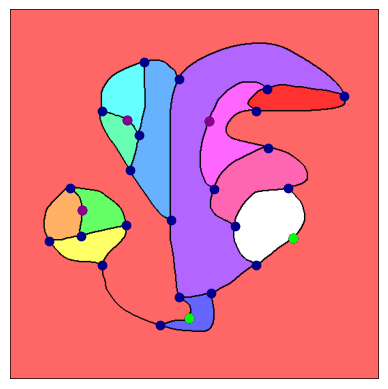

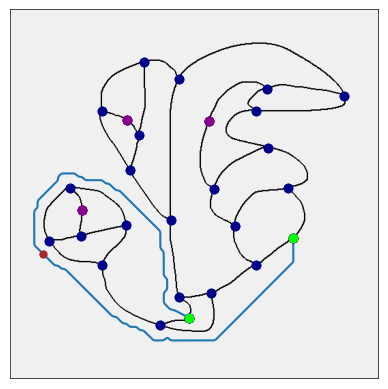

([[(261.546875, 451.453125), (414.7890625, 334.9453125)]],
 [[(261.546875, 451.453125),
   (250.436767578125, 445.547607421875),
   (249.7795867919922, 445.2008819580078),
   (249.13856506347656, 444.86534118652344),
   (248.51370239257812, 444.5409851074219),
   (247.90499877929688, 444.2278137207031),
   (247.3124542236328, 443.9258270263672),
   (246.73606872558594, 443.63502502441406),
   (246.17584228515625, 443.35540771484375),
   (245.63177490234375, 443.08697509765625),
   (245.10386657714844, 442.82972717285156),
   (244.5921173095703, 442.5836639404297),
   (244.09652709960938, 442.3487854003906),
   (243.61709594726562, 442.1250915527344),
   (243.15382385253906, 441.91258239746094),
   (242.7067108154297, 441.7112579345703),
   (242.2757568359375, 441.5211181640625),
   (241.8609619140625, 441.3421630859375),
   (241.4623260498047, 441.1743927001953),
   (241.07984924316406, 441.01780700683594),
   (240.71353149414062, 440.8724060058594),
   (240.36337280273438, 440.7381896

In [50]:
main(False, True)

Path does not exist from: (206.330078125, 161.1484375) to (140.166015625, 293.0625)
Path does not exist from: (206.330078125, 161.1484375) to (326.103515625, 163.5546875)
Path does not exist from: (206.330078125, 161.1484375) to (131.759765625, 233.609375)
Path does not exist from: (140.166015625, 293.0625) to (326.103515625, 163.5546875)
Path does not exist from: (140.166015625, 293.0625) to (131.759765625, 233.609375)
Path does not exist from: (326.103515625, 163.5546875) to (131.759765625, 233.609375)


Enter a number between 0 and -1 0


* * * * * * *


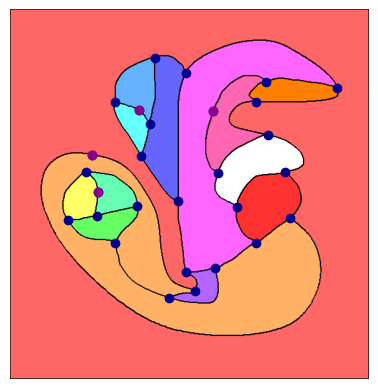

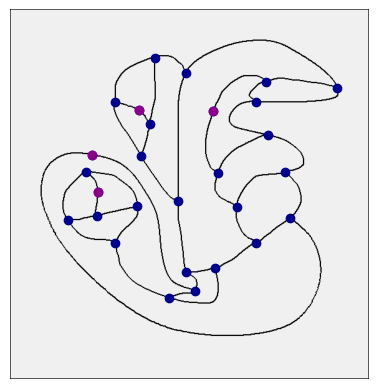

([], 0)

In [52]:
main(False, True)